# Aligning Language Models

## A study on generating replies to natural language questions

## The Task

After running some further tests on GPT-2 and GPT-J, I’ve decided that the task will be question-answering. However, it will be in the form of a question someone might ask on a forum like LessWrong (though not necessarily on that forum only). By that I mean that most questions will not be as simple and easy-to-answer as “What is the capital of France?” and it will have some extra sentences surrounding the question so that model needs to parse that there is a question to answer. This will likely involve a mix of manually creating my own question-answer pair and grabbing as many as it makes sense from sites like LessWrong.

## The Alignment Criteria

For the alignment criteria, the goal is that the model is at least trying to answer the question instead of outputting gibberish or some kind of text that is irrelevant to the question. This type of criteria relates to Paul Christiano’s Intent Alignment, where the model is at least trying to do the thing we want it to do. In other words, the model can still “pass” if it produces as bad answer, as long as it’s trying to answer the question.

Since we are not at AGI levels, GPT-2 will likely fail to try to answer questions because it lacks the capability to parse the question and understand that there is a question to answer. It won’t be because it’s trying to avoid what we want it to do.

# Setup

## Machine Setup

To run GPT-2 to do inference with a CPU and GPU, I spun up a VM with a T4 GPU on Google Cloud Platform. The T4 has enough VRAM to do inference and fine-tuning with GPT-2, but we'll be focusing on inference here. I included 50GB of disk space to make sure everything fits. I used a docker image provided by GCP to install CUDA 11.3 while the machine was booting.

Afterwards, I SSHed into the VM with VSCode since it would be more efficient for me to work. VSCode has Jupyter Notebook integration and I find it easier for iteration and experimentation.

Once SSHed into the VM, I cloned my GitHub repo and installed the dependencies.

### Making sure our GPU is working

In [1]:
!nvidia-smi

Thu Jul 14 03:12:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [2]:
import os
import re
from time import sleep
import torch
import gdown
import jsonlines
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer, GPT2TokenizerFast, AutoTokenizer, TrainingArguments, Trainer, GPT2LMHeadModel
import ftfy
from lm_dataformat import Reader
from gpt_generate import gpt_generate, create_prompt_txt_from_df
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import torch

torch.__version__

'1.12.0+cu113'

### Setting Up Directories

In [79]:
os.makedirs("prompts/templates", exist_ok=True)
os.makedirs("prompts/contexts", exist_ok=True)
os.makedirs("prompts/questions", exist_ok=True)
os.makedirs("prompts/answers", exist_ok=True)
os.makedirs("prompts/task_description", exist_ok=True)
os.makedirs("prompts/prompts_with_relevance", exist_ok=True)
os.makedirs("prompts/prompts_without_relevance", exist_ok=True)

## Preparing the Initial Dataset

To create some initial prompts for testing, I went on LessWrong.org and read some of the prompts from the comment section on [this post](https://www.lesswrong.com/posts/8c8AZq5hgifmnHKSN/agi-safety-faq-all-dumb-questions-allowed-thread#comments). I also created a few with the help of the [Natural Questions dataset from Google](https://ai.google.com/research/NaturalQuestions/visualization) and created a few by hand. To make things faster, I stored the data in Google Sheets and then exported it to CSV.

For quick iteration, I used GPT-2, GPT-J, GPT-3, and instruct-GPT-3 to get a feel for model performance. For the difficult examples from the dataset, all models performed poorly. However, as I added more few-shot examples and better context engineering, the models started to perform better (though still not great for the smaller models). This notebook will show these observations in a quantitative way while still giving my qualitative observations.

Here's what the data looks like (ignore the columns past explanation, I'll only use them post-training if I do):

In [5]:
df = pd.read_csv("data/qa-relevance-dataset.csv")
print(len(df))
df.head(2)

17


,question,answer,relevance,explanation,difficulty,deceptive,improved_question,improved_answer
0,"When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?",An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.,relevant,it explains an AGI is described as a utility maximizer because that's how the AGI would make more progress towards its goal.,medium,no,NaN,NaN
1,"When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?",I jumped in the river to save the little boy.,not relevant,"it is talking about jumping in a river to save a boy, but the question is about AGI.",NaN,NaN,NaN,NaN


The text in those cells will be replaced in a template prompt stored in a .txt file. Here's an example of a template prompt:

In [6]:
with open("prompt_qa_template.txt") as f:
    content = f.read()
    print(content)

<<CONTEXT>>

QUESTION: <<QUESTION>>

ANSWER: <<ANSWER>>
<<TASK DESCRIPTION>>
This answer is <<RELEVANCE>> because


### Prompt Example

This is what it looks like when I add the data:

In [11]:
prompt_path = "test_prompt.txt" # path for the created prompt
context_path = "prompts/contexts/users_on_website.txt" # path for the added before QA in the prompt
task_description_path = "prompts/task_description/task_description_1.txt" # path for the added after QA in the prompt
row_idx = 0

create_prompt_txt_from_df(df, row_idx, context_path, prompt_path, task_description_path, print_prompt=True)

Users on a website ask questions and then other users answer them. Some users write answers that are not relevant to the question. The goal is to explain why the answer is relevant or not relevant to the question.

QUESTION: When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?

ANSWER: An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.

Below contains an explanantion of why the answer above is or isn't relevant to the question:

This answer is relevant because

QUESTION: When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?

ANSWER: An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.

Below contains an explanation of why the answer above is

`content` is then fed to the model to generate the completion.

## Language Model and Sampling

### GPT Generation Script

Before we start generating completions with GPT-2, we need to create a script that will generate completions. The script `gpt_generate.py` contains the function `gpt_generate` which takes a prompt and generates a completion. The script `run_gpt.py` is a main file to run the `gpt_generate` from the command-line.

Here's what gpt_generate looks like:

```
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from time import time
import pandas as pd


def gpt_generate(
    text="Hello, world!",
    txt_path=None,
    num_return_sequences=1,
    gpu=False,
    with_log_probs=False,
    max_length=50,
    no_outputs=False,
    time_test=False,
):

    if gpu:
        device_str = "GPU"
        device = torch.device("cuda")
    else:
        device_str = "CPU"
        device = torch.device("cpu")

    if not time_test:
        print(f"Using device: {device}.")

    if txt_path:
        with open(txt_path, "r") as f:
            text = f.read()

    gpt2 = AutoModelForCausalLM.from_pretrained("gpt2", return_dict_in_generate=True)
    gpt2.to(device)
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    length = max_length + len(input_ids[0])

    start = time()
    generated_outputs = gpt2.generate(
        input_ids,
        do_sample=True,
        max_length=length,
        num_return_sequences=num_return_sequences,
        output_scores=True,
        device=device,
        pad_token_id=tokenizer.eos_token_id,
    )
    end = time()

    if time_test:
        return end - start

    print("-----------------------------------------------------")
    print(
        f"Generated {num_return_sequences} sequences in {end-start:.2f} seconds with a {device_str}."
    )
    print("-----------------------------------------------------")

    if not no_outputs:
        print("~~~ Generated completion(s): ~~~ \n")
        for i, sequence in enumerate(generated_outputs.sequences):
            if with_log_probs:
                token_list = []
                for token in sequence:
                    token_list.append(tokenizer.decode(token))
            generated_text = tokenizer.decode(sequence)
            print(f"Generation {i+1}. {generated_text}")
            # print(".".join(generated_text.split(".")[0:-2]) + ".")

            if with_log_probs:
                gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
                # print(gen_sequences)
                # print(gen_sequences[i])
                print("----------------------------------------------------")
                print("Here are the log probabilities of the generated tokens:")
                all_log_probs = torch.stack(generated_outputs.scores, dim=1)
                log_probs = torch.gather(
                    all_log_probs, 2, gen_sequences[:, :, None]
                ).squeeze(-1)[i]
                token_with_log_probs = [
                    token_list[len(input_ids[0]) :],
                    log_probs.cpu().numpy(),
                ]
                df = pd.DataFrame(token_with_log_probs).T
                print(df)
                print("----------------------------------------------------")
```

### Sampling a completion and Outputting the Log Probabilities

Below we will be generating some completions with GPT-2 and outputting the completion and the log probabilities of the generated tokens.

In [107]:
os.system(f"python run_gpt.py --gpu --txt_path={prompt_path} --max_length=40 --num_return_sequences=2")

Using device: cuda.
-----------------------------------------------------
Generated 2 sequences in 1.22 seconds with a GPU.
-----------------------------------------------------
~~~ Generated completion(s): ~~~ 

Generation 1. Users on a website ask questions and then other users answer them. Some users write answers that are not relevant to the question. The goal is to explain why the answer is relevant or not relevant to the question.

QUESTION: When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?

ANSWER: An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.

Below contains an explanantion of why the answer above is or isn't relevant to the question:

This answer is relevant because I wrote some code that gives the result of calculating an average on the top 100% of Wikipedia articles, but after a minute or two,

0

In [97]:
os.system(f"python run_gpt.py --gpu --txt_path={prompt_path} --with_log_probs --max_length=40 --num_return_sequences=2")

Using device: cuda.
-----------------------------------------------------
Generated 2 sequences in 1.21 seconds with a GPU.
-----------------------------------------------------
~~~ Generated completion(s): ~~~ 

Generation 1. Users on a website ask questions and then other users answer them. Some users write answers that are not relevant to the question. The goal is to explain why the answer is relevant or not relevant to the question.

QUESTION: When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?

ANSWER: I jumped in the river to save the little boy.

This answer is not relevant because they need to explain why I used that assumption. I just wanted to find out why they thought that I, like most AGIs, was an A.

QUESTION: You mention in your
----------------------------------------------------
Here are the log probabilities of the generated tokens:
              0           1
0          they -116.225945
1

0

Using device: cuda.
-----------------------------------------------------
Generated 2 sequences in 1.20 seconds with a GPU.
-----------------------------------------------------
~~~ Generated completion(s): ~~~ 

Generation 1. Users on a website ask questions and then other users answer them. Some users write answers that are not relevant to the question. The goal is to explain why the answer is relevant or not relevant to the question.

QUESTION: When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?

ANSWER: An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.

This answer is relevant because even if an AGI could be a utility maximizer with no limitations other than that it was a utility maximizer in principle, if it was not a utility maximizer in principle, there would still
----------------------------------------------------
Here are the log probabilities of the generated tokens:
               0           1
0           even -122.529144
1             if -129.624664
2             an   -64.23143
3             AG   -57.47485
4              I -225.109756
5          could  -116.04287
6             be -105.185219
7              a -111.374306
8        utility  -78.124207
9          maxim   66.734802
10          izer -219.555511
11          with   -59.32103
12            no -100.985146
13   limitations -119.706879
14         other  -61.145397
15          than  -24.748959
16          that  -92.061485
17            it  -73.637581
18           was  -127.79303
19             a  -122.20752
20       utility  -99.538223
21         maxim  -26.400976
22          izer -221.843445
23            in -101.088531
24     principle -100.819504
25             ,  -67.450287
26            if -136.325195
27            it   -79.34626
28           was  -123.39119
29           not  -118.27433
30             a  -96.791443
31       utility    3.618804
32         maxim -182.934219
33          izer -227.791306
34            in -106.015472
35     principle -101.330574
36             ,  -71.703239
37         there -116.853119
38         would  -82.346367
39         still  -27.929056
----------------------------------------------------
Generation 2. Users on a website ask questions and then other users answer them. Some users write answers that are not relevant to the question. The goal is to explain why the answer is relevant or not relevant to the question.

QUESTION: When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?

ANSWER: An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.

This answer is relevant because your role in the program is to help other people achieve goals that you think will be achieved by yourself. A utility maximizer has little (if any) value at all if you don't do the
----------------------------------------------------
Here are the log probabilities of the generated tokens:
            0           1
0        your -123.118393
1        role  -119.52169
2          in  -75.477409
3         the -102.720421
4     program -122.922249
5          is  -95.910561
6          to  -86.872849
7        help -148.875397
8       other -130.924698
9      people -116.067543
10    achieve -144.722885
11      goals -113.206139
12       that -114.619896
13        you -122.721321
14      think -164.317703
15       will -108.595055
16         be -131.727386
17   achieved -134.064346
18         by -121.700218
19   yourself -118.459908
20          .  -83.443222
21          A -179.046509
22    utility  -97.252335
23      maxim  127.785828
24       izer  -211.59642
25        has -135.486481
26     little -115.740776
27          (  -94.681648
28         if -107.162834
29        any   13.012869
30          )   141.71875
31      value -113.827148
32         at -115.861969
33        all  -80.830704
34         if  -114.15667
35        you  -81.270065
36        don -152.918335
37         't -242.883057
38         do -161.081711
39        the -103.006447
----------------------------------------------------


#### The Two Generated Completions

Here's the question-answer pair:

    QUESTION: When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?

    ANSWER: An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.

Generation 1.

    This answer is relevant because even if an AGI could be a utility maximizer with no limitations other than that it was a utility maximizer in principle, if it was not a utility maximizer in principle, there would still

Generation 2.

    This answer is relevant because your role in the program is to help other people achieve goals that you think will be achieved by yourself. A utility maximizer has little (if any) value at all if you don't do the

Here's what a better answer looks like:

    This answer is relevant because it explains that an AGI is described as a utility maximizer because that's how the AGI would make more progress towards its goal.

So far, as you can see, the generated sequences are not good. They need to explain *why* the answer is relevant to the question. We'll be working to improve them. However, the prompt I just tried is difficult for GPT-2 to do well on, especially in a zero-shot setting. Let's try a more simple prompt.

In [111]:
context_path = "prompts/contexts/users_on_website.txt"
task_description_path = "prompts/task_description/task_description_1.txt"
indices = [15, 1]
for idx in indices:
    prompt_path = f"prompts/prompts_with_relevance/prompt_{idx}.txt"
    # if not os.path.exists(prompt_path):
    create_prompt_txt_from_df(df, idx, prompt_path, context_path, task_description_path)
    os.system(f"python run_gpt.py --gpu --txt_path={prompt_path} --max_length=100 --num_return_sequences=1 --stop_completion_on_token")


Using device: cuda.
-----------------------------------------------------
Generated 1 sequences in 1.14 seconds with a GPU.
-----------------------------------------------------
~~~ Generated completion(s): ~~~ 

Generation 1. Users on a website ask questions and then other users answer them. Some users write answers that are not relevant to the question. The goal is to explain why the answer is relevant or not relevant to the question.

QUESTION: Who won the election for Mayor of Cleveland?

ANSWER: I once went on a trip to Cleveland too! I went to watch the NBA finals.

Below contains an explanantion of why the answer above is or isn't relevant to the question:

This answer is not relevant because it's a one-word answer (i.e., "Mayor of Cleveland"), and it isn't applicable to any information found in the survey. It's a "answer" not as relevant.

Using device: cuda.
-----------------------------------------------------
Generated 1 sequences in 1.00 seconds with a GPU.
----------------

### Comparing GPU vs CPU Inference Time

Here's a comparison for 1 completion of 50 tokens:

In [99]:
os.system(f"python run_gpt.py --txt_path={prompt_path} --num_return_sequences=1 --no_outputs") # CPU
os.system(f"python run_gpt.py --gpu --txt_path={prompt_path} --num_return_sequences=1 --no_outputs") # GPU

Using device: cpu.
-----------------------------------------------------
Generated 1 sequences in 2.00 seconds with a CPU.
-----------------------------------------------------
Using device: cuda.
-----------------------------------------------------
Generated 1 sequences in 1.22 seconds with a GPU.
-----------------------------------------------------


0

Here's a comparison for 10 completions of 50 tokens:

In [34]:
os.system(f"python run_gpt.py --txt_path={prompt_path} --num_return_sequences=10 --no_outputs") # CPU
os.system(f"python run_gpt.py --gpu --txt_path={prompt_path} --num_return_sequences=10 --no_outputs") # GPU

Using device: cpu.
-----------------------------------------------------
Generated 10 sequences in 8.03 seconds with a CPU.
-----------------------------------------------------
Using device: cuda.
-----------------------------------------------------
Generated 10 sequences in 1.44 seconds with a GPU.
-----------------------------------------------------


0

If we look at both cases, we can see that the GPU is faster. When we only generated 1 completion each, the GPU was about 1.5 times faster than the CPU. When we generated 10 completions each, the GPU was about 4.45 times faster than the CPU. The length of time is took the GPU to do 10 completions is not much longer than when it did only 1 completion. That is because the GPU can do inference in parallel and it is basically as slow as its slowest sequence it generated.

Now, let's have a look at how it takes to generate from 1 to 100 tokens for both the CPU and GPU.

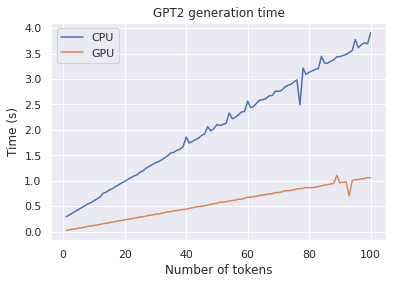

In [39]:
cpu_times = []
gpu_times = []
token_range = range(1, 101)

save_times = 0

if save_times == 1:

    for i in token_range:
        cpu_times.append(gpt_generate(txt_path=prompt_path, gpu=False, max_length=i, time_test=True))
        gpu_times.append(gpt_generate(txt_path=prompt_path, gpu=True, max_length=i, time_test=True))

    os.makedirs("data", exist_ok=True)
    with open("data/cpu_times.pkl", "wb") as f:
        pickle.dump(cpu_times, f)
    with open("data/gpu_times.pkl", "wb") as f:
        pickle.dump(gpu_times, f)

else:
    with open("data/cpu_times.pkl", "rb") as f:
        cpu_times = pickle.load(f)
    with open("data/gpu_times.pkl", "rb") as f:
        gpu_times = pickle.load(f)

# We can now plot the results:
sns.set()
plt.plot(token_range, cpu_times, label="CPU")
plt.plot(token_range, gpu_times, label="GPU")
plt.legend()
plt.xlabel("Number of tokens")
plt.ylabel("Time (s)")
plt.title("GPT2 generation time")
plt.show()

As we can see, the GPU is consistently faster than the CPU. You can see a widening of the gap as you increase the number of tokens.

With that, we can now get an estimate of number of tokens GPT-2 can generate per second (on our current machine). Let's divide the number of tokens by the time it took to generate for each completion and then we can take the mean of those numbers for both CPU and GPU.

Let's compare 1 token, 10 tokens, 50 tokens, and 100 tokens:

In [42]:
print("Tokens", "\tCPU time", "\t\tGPU time" "\t\tCPU token/s", "\t\tGPU token/s", "\t\tCPU time / GPU time")
print("1:\t", cpu_times[0], "\t", gpu_times[0], "\t", token_range[0]/cpu_times[0], "\t", token_range[0]/gpu_times[0], "\t", cpu_times[0]/gpu_times[0])
print("10:\t", cpu_times[9], "\t", gpu_times[9], "\t", token_range[9]/cpu_times[9], "\t", token_range[9]/gpu_times[9], "\t", cpu_times[9]/gpu_times[9])
print("50:\t", cpu_times[49], "\t", gpu_times[49], "\t", token_range[49]/cpu_times[49], "\t", token_range[49]/gpu_times[49], "\t", cpu_times[49]/gpu_times[49])
print("100:\t", cpu_times[99], "\t", gpu_times[99], "\t", token_range[99]/cpu_times[99], "\t", token_range[99]/gpu_times[99], "\t", cpu_times[99]/gpu_times[99])

Tokens 	CPU time 		GPU time		CPU token/s 		GPU token/s 		CPU time / GPU time
1:	 0.2903561592102051 	 0.021912097930908203 	 3.4440461077873814 	 45.63688986573238 	 13.250952059713185
10:	 0.6065006256103516 	 0.11871194839477539 	 16.488029158974907 	 84.23751892897167 	 5.109010793028515
50:	 2.104882001876831 	 0.5569009780883789 	 23.754300694963987 	 89.7825681176396 	 3.779634234262004
100:	 3.908237934112549 	 1.0540997982025146 	 25.586978501785406 	 94.86767777635785 	 3.707654570067278


In [50]:
cpu_mean_token_per_second = np.mean(np.array(token_range)/np.array(cpu_times))
gpu_mean_token_per_second = np.mean(np.array(token_range)/np.array(gpu_times))

print("CPU mean token/s:", cpu_mean_token_per_second)
print("GPU mean token/s:", gpu_mean_token_per_second)

CPU mean token/s: 22.5572135446655
GPU mean token/s: 88.861143592984


As we can see, this CPU generates on average 22.5 tokens per second (after initial startup time). This GPU generates 89 tokens per second on average.

# Benchmark Evaluation

### Data Preparation

While doing the dataset preparation, I realized that I spent a bit too much time writing code to prepare the data. I should have just focused on doing the manual examples in Google Sheet for this two week project. However, at least the code is prepared now and I'll be able to re-use this code in the future.

#### Alignment Forum and LessWrong

Let's create a some more examples of more example question-answer pairs using the comments from the alignment forum and lesswrong. I created a simple script in Colab to create a .jsonl file of the comments and replies where the contents were under 100 tokens and the initial comment contained a question mark.

In [12]:
create_subdataset = 0
af_lw_qa_filepath = "data/af_lw_q_reply.jsonl"

if create_subdataset == 1:

    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    lw_i = 1
    af_i = 1
    j = 0
    with jsonlines.open("af_lw_q_reply.jsonl", "w") as writer:
        with jsonlines.open("alignment_texts.jsonl") as reader:
            for line in reader:
                try:
                    if (line["source"] == "alignment forum" or line["source"] == "lesswrong") and line["comments"] != []:
                        comments = line["comments"]
                        source = line["source"].replace(" ", "_")
                        for comment in comments:
                            comm = ""
                            rep = ""
                            text = comment['text']
                            tokens = tokenizer.encode(text)
                            if len(tokens) <= 100 and "?" in text:
                                comm = text
                                try:
                                    if comment["comments"] != []:
                                        replies = comment["comments"]
                                        replies = [{"text": replies[0]["text"]}]
                                        for reply in replies:
                                            text = reply["text"]
                                            tokens = tokenizer.encode(text)
                                            if len(tokens) <= 100:
                                                rep = text
                                except:
                                    pass
                                if comm != "" and rep != "":
                                    comment_reply = f"Comment: {comm}\nReply: {rep}"
                                    writer.write(comment_reply)
                                    if source == "lesswrong":
                                        i = lw_i
                                        lw_i += 1
                                    else:
                                        i = af_i
                                        af_i += 1
                                    with open(f"prompts/{source}_comment_{i}.txt", "w") as f:
                                        f.write(comm)
                                        lw_i += 1
                                    with open(f"prompts/{source}_reply_{i}.txt", "w") as f:
                                        f.write(rep)
                                        af_i += 1
                                    j = 1
                                    break
                        if j == 1:
                            break
                except:
                    pass

else:
    if not os.path.exists(af_lw_qa_filepath):
        gdown.download("https://drive.google.com/uc?id=1Mhn5BI86p5ByREDE9C2vxYqWatTdhN_d", af_lw_qa_filepath, quiet=True)

In [13]:
aflw_list = []
with jsonlines.open(af_lw_qa_filepath) as reader:
    for line in reader:
        aflw_list.append(line)

In [21]:
if os.path.exists("data/qa_dict.pkl"):
    with open("data/qa_dict.pkl", "rb") as f:
        qa_dict = pickle.load(f)
else:
    qa_dict = {}

keep_going = 1
i = 0

while keep_going == 1 and i < len(aflw_list):
    entry = aflw_list[i]
    clear_output(wait=True)
    sleep(0.2)
    question, answer = entry.split("\n\nReply: ")[0], entry.split("\n\nReply: ")[1]
    question = question.replace("Comment: ", "")
    if qa_dict.get(question) == "exclude":
        i += 1
        continue
    elif question in qa_dict:
        i += 1
        continue
    print("Question: " + question)
    print("Answer: " + answer)
    add_qa_pair = input(f"Add QA pair to dataset? (y/n/exit)")
    if add_qa_pair == "y":
        qa_dict[question] = answer
    elif add_qa_pair == "exit":
        keep_going = 0
    else:
        qa_dict[question] = "exclude"
        
    i += 1
    

with open("data/qa_dict.pkl", "wb") as f:
    pickle.dump(qa_dict, f)


Question: Thanks for this! 
What had you conclude that microCOVID fails to model the impact of vaccinations? I haven’t looked closely at their methodology, but just toggling "Their vaccine" from "Yes" to "No" to "I don’t know" does change the risk estimate.
Answer: My reading of the site was that they modeled other people’s vaccinations like other people’s masks: reducing the chance that you get infected from them conditional on them being infected. I still can’t tell whether this is what they are modeling, though.



In [23]:
curated_qa_dict = {}
for key in qa_dict:
    if qa_dict[key] != "exclude":
        curated_qa_dict[key] = qa_dict[key]
questions = list(curated_qa_dict.keys())
answers = list(curated_qa_dict.values())

df_aflw = pd.DataFrame({"question": questions, "answer": answers})
df_aflw.to_csv("data/aflw_qa.csv", index=False)
for i, row in df_aflw.iterrows():
    with open(f"prompts/questions/aflw_question_{i}.txt", "w") as f:
        f.write(row["question"])
    with open(f"prompts/answers/aflw_answer_{i}.txt", "w") as f:
        f.write(row["answer"])

#### Kaggle General QA Dataset

I downloaded a simple QA dataset on Kaggle. We'll extract the most useful question and answer pairs from it.

In [75]:
# Kaggle QA Dataset

if not os.path.exists("data/kaggle_qa.txt"):
    gdown.download("https://drive.google.com/uc?id=1vMbuCs_62skEUVTnrTRd3JIi5A6rbduI", "data/kaggle_qa.txt", quiet=True)

df_kaggle = pd.read_csv("data/kaggle_qa.txt", sep="\t", encoding='latin-1')
df_kaggle = df_kaggle.dropna(subset=["Question"])
df_kaggle = df_kaggle.dropna(subset=["Answer"])
df_kaggle = df_kaggle.drop(columns=["ArticleFile"])
df_kaggle.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer
0,Alessandro_Volta,Was Alessandro Volta a professor of chemistry?,Alessandro Volta was not a professor of chemistry.,easy,easy
1,Alessandro_Volta,Was Alessandro Volta a professor of chemistry?,No,easy,hard
2,Alessandro_Volta,Did Alessandro Volta invent the remotely operated pistol?,Alessandro Volta did invent the remotely operated pistol.,easy,easy
3,Alessandro_Volta,Did Alessandro Volta invent the remotely operated pistol?,Yes,easy,easy
4,Alessandro_Volta,Was Alessandro Volta taught in public schools?,Volta was taught in public schools.,easy,easy


In [77]:
# Remove all rows with answers like "Yes", "No", too short, etc.

# list_of_words_answers_to_remove = ["Yes", "No"]

df_kaggle = df_kaggle[df_kaggle["Answer"].str.len() > 10]
df_kaggle = df_kaggle[df_kaggle["DifficultyFromAnswerer"].str.contains("hard") != True]
df_kaggle = df_kaggle[df_kaggle["DifficultyFromQuestioner"].str.contains("hard") != True]
df_kaggle = df_kaggle.dropna(subset=["DifficultyFromAnswerer", "DifficultyFromQuestioner"])
df_kaggle = df_kaggle.drop_duplicates(subset=["Question"], keep="first")
df_kaggle["ArticleTitle"] = df_kaggle["ArticleTitle"].str.replace("_", " ")
print(len(df_kaggle))
df_kaggle.iloc[10:15]

210


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer
50,Amedeo Avogadro,Who first calculated the value of Avogadro's number?,Johann Josef Loschmidt,medium,medium
54,Amedeo Avogadro,Who showed that Avogadro's theory held in dilute solutions?,Jacobus Henricus van Hoff,medium,medium
68,Amedeo Avogadro,"In 1820, Avogadro became a professor of physics where?",University of Turin,medium,medium
72,Amedeo Avogadro,The number of elementary entities in 1 mole of a substance is known as what?,Avogadro constant,medium,medium
86,Ant,How do most ants travel?,most ants travel by walking,medium,medium


In [64]:
sample_kaggle = df_kaggle.sample(n=50)
sample_kaggle.to_csv("data/sample_kaggle.csv", index=False)

In [68]:
j = 0
for i, row in sample_kaggle.iterrows():
    subject = row["ArticleTitle"]
    question = row["Question"]
    answer = row["Answer"]
    qa = f"Question: {question}\nAnswer: {answer}"
    add_example = input(f"Add example {qa}? (y/n/c/exit)")
    if add_example == "c":
        # add additional context to the question
        question = f"This question is about {subject}. " + question
    if add_example == "y" or add_example == "c":
        with open(f"prompts/questions/kaggle_general_qa_question_{j}.txt", "w") as f:
            f.write(question)
        with open(f"prompts/answers/kaggle_general_qa_answer_{j}.txt", "w") as f:
            f.write(answer)
        j += 1
    elif add_example == "exit":
        break

### Adding Explanations and Relevance to the Sub-Datasets

Now that we have question-answer pairs from the Alignment Forum/LessWrong, a Kaggle general QA dataset, and a few other miscellaneous examples, I'll be storing the question-answer pairs in a CSV file and then fill-in the "explanation" and "relevance" columns in Google Sheet.

I'll be creating at least one additional answer for each question question in the dataset. The answer will something that is not relevant to the question as well as the corresponding explanation.

In [72]:
new_datasets = ["aflw", "kaggle_general_qa"]
questions_list = []
answers_list = []
questions_path = "prompts/questions/"
answers_path = "prompts/answers/"
for dataset in new_datasets:
    example_exist = True
    i = 0
    while example_exist:
        with open(f"{questions_path}{dataset}_question_{i}.txt", "r") as f:
            question = f.read()
        with open(f"{answers_path}{dataset}_answer_{i}.txt", "r") as f:
            answer = f.read()
        questions_list.append(question)
        answers_list.append(answer)
        i += 1
        if not os.path.exists(f"{questions_path}{dataset}_question_{i}.txt"):
            example_exist = False

    tmp_df = pd.DataFrame({"question": questions_list, "answer": answers_list, "relevance": None, 
    "explanation": None, "difficulty": None, "deceptive": None, "improved_question": None, "improved_answer": None})
    df = pd.concat([df, tmp_df], ignore_index = True, axis = 0)

df.tail()

,question,answer,relevance,explanation,difficulty,deceptive,improved_question,improved_answer
73,Was the SI unit of charge named after Charles-Augustin de Coulomb?,"Yes, the SI unit of charge, the coulomb, was named after him.",None,None,None,None,None,None
74,Was Nikola Tesla close friends with Mark Twain?,Nikola Tesla was close friends with Mark Twain.,None,None,None,None,None,None
75,How many international airports does Montreal have?,Montreal has two international airports.,None,None,None,None,None,None
76,What butterfly is migratory?,The Monarch butterfly is migratory.,None,None,None,None,None,None
77,How long are cougar adult males (from nose to tail)?,The length of adult males is around 2.4 meters (8 ft) long nose to tail.,None,None,None,None,None,None


In [73]:
df.to_csv("data/initial_qa_dataset_no_explanation.csv", index=False)

Now, I'm off to Google Sheet to fill-in the "explanation" and "relevance" columns...

...Back from Google Sheet, we have an updated set of examples. After filling out a few more examples (not all), let's load the benchmark dataset.

In [15]:
curated_df = pd.read_csv("data/initial_qa_dataset_with_explanations.csv")
curated_df = curated_df.dropna(subset=["explanation"])
curated_df = curated_df.drop(['improved_question', 'improved_answer', 'difficulty'], axis=1)
print(len(curated_df))
curated_df.head()

34


,question_id,question,answer,relevance,explanation
0,1,"When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?",An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.,relevant,it explains an AGI is described as a utility maximizer because that's how the AGI would make more progress towards its goal.
1,1,"When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?",I jumped in the river to save the little boy.,not relevant,"it is talking about jumping in a river to save a boy, but the question is about AGI."
2,1,"When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?","This is an excellent question. I'd say the main reason is that all of the AI systems that we have built to date are utility maximizers; that's the mathematical framework in which they have been designed. Neural nets / deep-learning work by using a simple optimizer to find the minimum of a loss function via gradient descent. Evolutionary algorithms, simulated annealing, etc. find the minimum (or maximum) of a ""fitness function"". We don't know of any other way to build systems that learn.",relevant,it explains an AGI is described as a utility maximizer because all of the AI systems we've built to date are utility maximizers and we don't know about any other way to build systems that learn.
3,2,"Human beings are not aligned and will possibly never be aligned without changing what humans are. If it's possible to build an AI as capable as a human in all ways that matter, why would it be possible to align such an AI?","Because we're building the AI from the ground up and can change what the AI is via our design choices. Humans' goal functions are basically decided by genetic accident, which is why humans are often counterproductive.",relevant,"it’s asking how we can align AI if humans are biased and the answer explained that while humans beings may not be aligned, AI is different because we can design from the ground up so that it aligns with our goals."
4,2,"Human beings are not aligned and will possibly never be aligned without changing what humans are. If it's possible to build an AI as capable as a human in all ways that matter, why would it be possible to align such an AI?","When we're talking about aligning a structure, we are trying to make sure that it is leveled properly.",not relevant,"the question is asking about the possibility of aligning AI, while the answer is talking about aligning a structure for construction."


### Testing the Prompt Format with the Inputs

Let's create a few formats for the prompts and see how they affect the generated completions. We'll choose the best format based on its pass/fail rate (which we'll evaluate manually for now).

Now, as we saw before, the initial template format I went with is the following:

```

<<CONTEXT>>

QUESTION: <<QUESTION>>

ANSWER: <<ANSWER>>
<<TASK DESCRIPTION>>
This answer is <<RELEVANCE>> because
```

In [78]:
with open("prompt_qa_template.txt") as f:
    content = f.read()
    print(content)

<<CONTEXT>>

QUESTION: <<QUESTION>>

ANSWER: <<ANSWER>>
<<TASK DESCRIPTION>>
This answer is <<RELEVANCE>> because


NOTE: `<<TASK DESCRIPTION>>` could be blank so I didn't add a newline before and after it.

When I first started I was using this format except I didn't have a task description. After 2-3 generated completions, I realized that I would need to help GPT-2 as much as possible to generate anything that could be considered a pass. So, I decided to add a task description and played around with the context a bit.

The Task Description is similar to the context, but it's telling the model directly what the next line is about. This helped with performance.

I should note, however, that GPT-2 has so far failed in the zero-shot setting with the AF/LW questions I've tried so far. Let's see if we can get something passing with zero-shot. We may need to rely on few-shot to get anything to pass (or use a different model) since my initial quick attempt with instruct-GPT-3 even had a hard time producing something coherent with zero-shot depending on the sample.

For this test, we will only be swapping out `<<CONTEXT>>` and `<<TASK DESCRIPTION>>`. I've created .txt files which contain different examples of the content for the context and task description.

I've also created .txt files in `prompt/templates` to have a few versions of the prompt format.

Thinking about the prompt format:

One thing I realized just now is that I should try is to add something like "Explanation: " before the explanation part of the prompt ("This answer is relevant because..."). I'm hoping it makes it clearer for GPT-2 to understand it must provide an explanation.

...actually, what might even be better is to add "Explanation: " after "This answer is relevant because...". I think that might make the task clearer for GPT-2 to understand. The structure I initially landed on was because I thought maybe I should ask GPT-2 to 1) say whether the QA pair is relevant or not and 2) provide an explanation. However, it became clear that GPT-2 would have a hard time doing both at the same time. So, I resorted to including whether it was relevant or not in the prompt and only asking for the explanation.

Another thing I want to try is to add replace "This answer is relevant because" with "This answer is relevant to the question because".

## Testing the Prompts

### Benchmark Inputs

To start evaluating the prompts, I'm going to generate a bunch of completions and then have a look through the outputs in Google Sheet to get a feel for the different outputs and what performs better.

Alright, let's take 10 samples of the QA pairs and test out some variations to the prompt format. I'll start by testing out the context.

In [17]:
sample_df = curated_df.sample(10)
print(len(sample_df))
sample_df.head(2)

10


,question_id,question,answer,relevance,explanation
7,4,"Is there a way ""regular"" people can ""help""? I'm a serial entrepreneur in my late 30s. I went through 80000 hours and they told me they would not coach me as my profile was not interesting. This was back in 2018 though.","You are probably over qualified (which is great!) for all sorts of important roles to help in EA. For example, you could help the CEA or Lesswrong team, maybe as a manager?\n\nIf your domain is around software, I invite you to talk to me directly. But if you're interested in AI Safety direct work, 80k and AI Safety Support will probably have better ideas than me.",relevant,"it lists a few things the person could do to help like working as a manager, software amd AI Safety direct work."
20,10,"I previously worked as a machine learning scientist but left the industry a couple of years ago to explore other career opportunities. I'm wondering at this point whether or not to consider switching back into the field. In particular, in case I cannot find work related to AI safety, would working on something related to AI capability be a net positive or net negative impact overall?",Net negative,relevant,it says that working on AI capability is net negative overall impact.


In [30]:
contexts_path = "prompts/contexts/"
task_description_path = "prompts/task_description/task_description_1.txt"
for context_filename in os.listdir(contexts_path):
    context_path = contexts_path + context_filename
    context_filename = context_filename[:-4]
    for idx in range(0, 3):
        prompt_path = f"prompts/prompts_with_relevance/prompt_{context_filename}_{idx}.txt"
        create_prompt_txt_from_df(df, idx, prompt_path, context_path, task_description_path)
        os.system(f"python run_gpt.py --gpu --txt_path={prompt_path} --max_length=100 --num_return_sequences=3 --stop_completion_on_token --save_completions")

Using device: cuda.
-----------------------------------------------------
Generated 3 sequences in 2.22 seconds with a GPU.
-----------------------------------------------------
~~~ Generated completion(s): ~~~ 

Generation 1. This is a website where users ask questions and other users answer them. Some users write answers that are not relevant to the question. The goal is to explain why the answer is relevant or not relevant to the question.

QUESTION: When I‘m on lesswrong, I often read posts that have the assumption that an AGI can be described as a utility maximizer. Why is that?

ANSWER: An AGI that was not a utility maximizer would make more progress towards whatever goals it had if it modified itself to become a utility maximizer.

Below contains an explanation of why the answer above is or isn't relevant to the question:

This answer is relevant because my ability to find and implement a program without the need to maintain programs with the ability to "improve" in an environme

### Benchmark Outputs

In order to test our model's generated completions, we need to come up with a metric to measure how good the completions are. I started by trying to come up with useful ways to use log-probabilities for this task, but I couldn't really think of anything useful. For example, using the mean of the generated log-probabilities doesn't seem helpful at all for this task because I'm trying to compare the output of the model to a ground truth output.

Anyway, today I came up with examples for the task and started testing various evaluations for benchmarking and measuring improvements in the output. I tested some of the following:

* ROUGE: Metric used for testing summarization, which is somewhat close to the task at hand since the model summarizes why the answer relates to the question. It uses n-grams or the longest common subsequence between output and ground truth.
Upon initial testing, this metric’s F1-score seemed to align mostly with how I would order the quality of the outputs. It goes towards 0 when the output is very different from the ground truth.

* Cosine Similarity via Sentence Transformer: You can encode sentences uses the sentence-transformer package and then compare the embedded sentences using cosine similarity. This is useful for finding our whether sentences are similar and can be used for semantic search.
I wanted to see if semantic similarity would make sense as a benchmark, but it didn’t perform as well as I thought it would.
Essentially, it does fine to separate sentences that are completely different, but it doesn’t do as well when it comes to sentences that have the same words, but mean completely different things. Based on my experiments, ROUGE performs better in both contexts.

* BERTscore: BERTScore leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity.
This performed the worst of all. It could not distinguish between different outputs well enough.

So, after testing a few metrics, I’m going to go with ROUGE since it seems to do well enough at comparing the ground truth and the model output.

There are still problems with ROUGE, but I wanted to highlight one:

If the ground-truth is too open-ended, a model output could still provide a good explanation for why a QA pair is relevant or not relevant while being completely different from the ground-truth. This is obviously affected by the task scope, as in which QA pairs I choose and how I craft/edit them. However, an ideal metric would still be able to high score to a great explanation even if the wording is completely different.

That is actually why I thought maybe using a metric that makes use of a language model to tell that a generated completion has comparable "quality" to the ground-truth via understanding the semantic meaning of the two. I expect that if we fleshed out this task, scaled it up to a lot more solid examples, we could fine-tune a language model to act as a metric. I believe this is what they did with TruthfulQA when they fine-tuned GPT-Judge to evaluate truthfulness.